In [1]:
import os
import xarray as xr
import numpy as np 
from pathlib import Path
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import Dataset,DataLoader
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
from torch.optim import Adam 
from einops import rearrange
import tqdm

In [2]:
from denoising_diffusion_pytorch import Unet
from tc_data_loader import TC_xy_Dataset 
from tc_diff_guided import Diffusion_model, count_parameters

/home/cw55/.conda/envs/tcdiff/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
timesteps = 300
results_folder = Path("./tc_guide_wvp_rand")

# Dataset

In [4]:
test_data  = TC_xy_Dataset(data_dir='./dataset/tc_data',
                               data_vars=['WVP'],
                               years=[126,127]) 

var WVP year 126: length 3724 
var WVP year 127: length 3521 


# Train the model 

In [5]:
# diffusion model
tc_diff_model = Diffusion_model(timesteps)

In [6]:
# decoder model
device = "cuda" if torch.cuda.is_available() else "cpu"
image_size = test_data.data.shape[-1]
channels = test_data.data.shape[1]

model = Unet(
    dim = 32,
    out_dim=channels,
    channels=channels*2, 
    dim_mults = (1,2,4,8), 
    resnet_block_groups = 4,
    flash_attn = False
)
model.to(device)
print('Total model parameter',count_parameters(model))
model.load_state_dict(torch.load(results_folder/'best_model.ckpt'))

Total model parameter 9201761


<All keys matched successfully>

# Sampling (inference)

In [7]:
def plot(gen_tc, ylabel, target=None, suptitle=None, **imshow_kwargs):
    
    num_rows , num_cols = gen_tc.shape[0],gen_tc.shape[1] 
    row_target = 1 if target is None else 2
    fig, axs = plt.subplots(figsize=(1*num_cols,1*num_rows*row_target), dpi = 100, nrows=num_rows*row_target, ncols=num_cols, squeeze=False)
    for row_idx in range(int(num_rows)): 
        for col_idx in range(num_cols):
            ax = axs[row_idx*row_target, col_idx] 
            ax.imshow(np.asarray(gen_tc[row_idx, col_idx]),vmin=20, vmax=80, cmap='jet', **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            if col_idx == 0 : ax.set(ylabel=ylabel[0])
            
            if target is not None:
                ax = axs[row_idx*row_target+1, col_idx] 
                ax.imshow(np.asarray(target[row_idx, col_idx]),vmin=20, vmax=80, cmap='jet', **imshow_kwargs)
                ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
                if col_idx == 0 : ax.set(ylabel=ylabel[1]) 
    if suptitle is not None: fig.suptitle(suptitle)
    plt.tight_layout()
    return fig

In [8]:
def gen_samples(sample_batch_size, obs_ratio_sample, target_data):
    minibatch_size = 128
    sample_all = []
    target_all = []
    for i in range(int(sample_batch_size/minibatch_size)):
        samples, target = tc_diff_model.sample(model, image_size=image_size, batch_size=minibatch_size, 
                                       channels=channels, obs_ratio=obs_ratio_sample,
                                       dataset=target_data) 
        sample_all.append(samples[-1])
        target_all.append(target)
    return np.concatenate(sample_all), np.concatenate(target_all)

sampling loop time step: 100%|██████████| 300/300 [00:25<00:00, 11.61it/s]


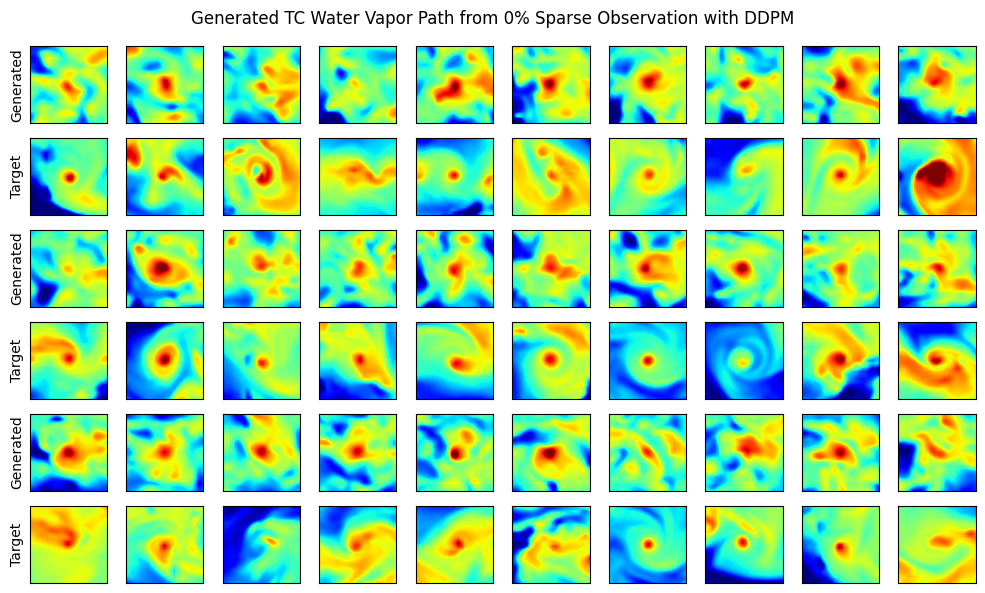

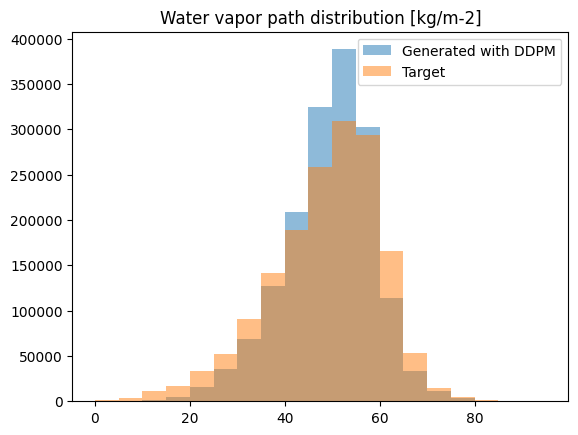

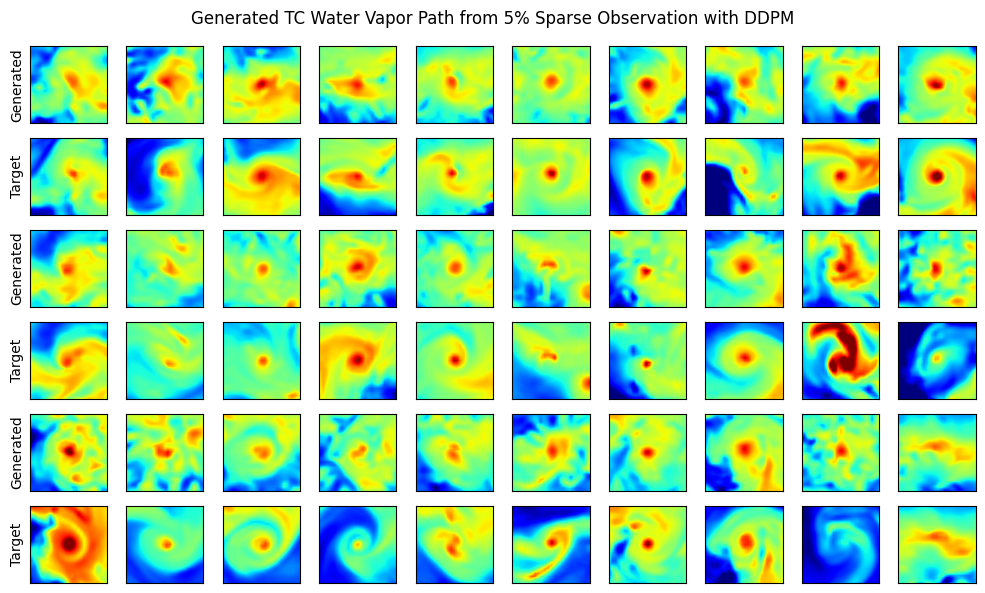

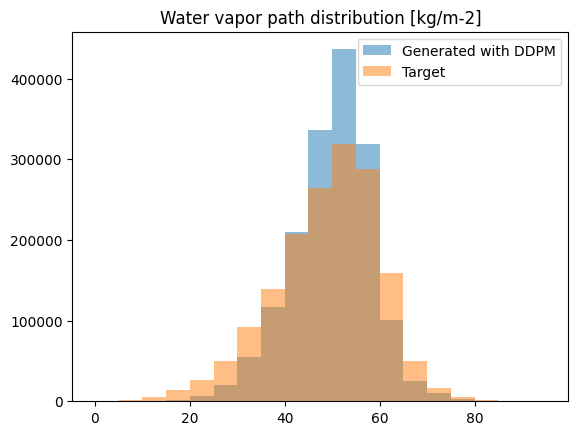

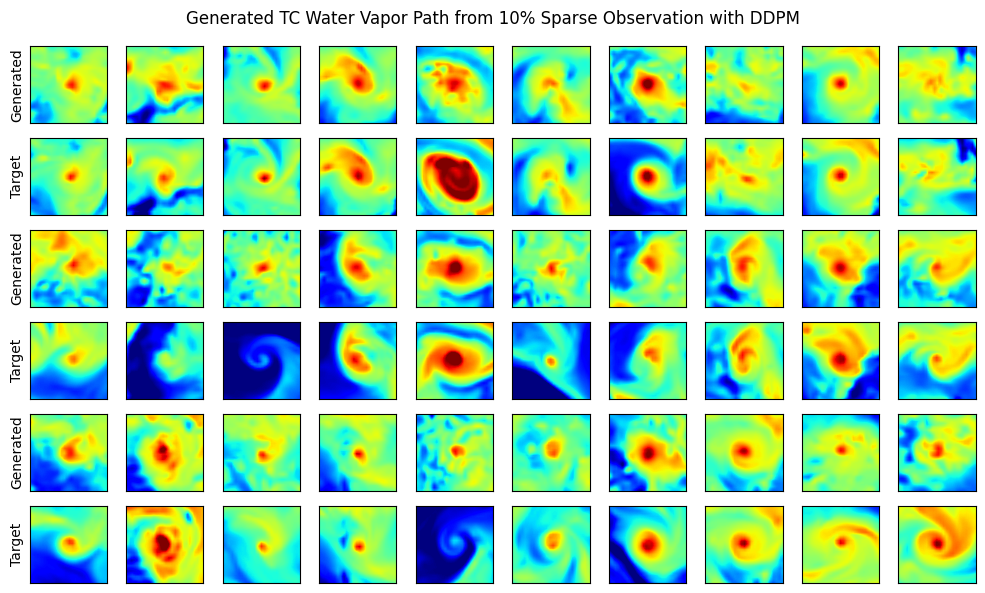

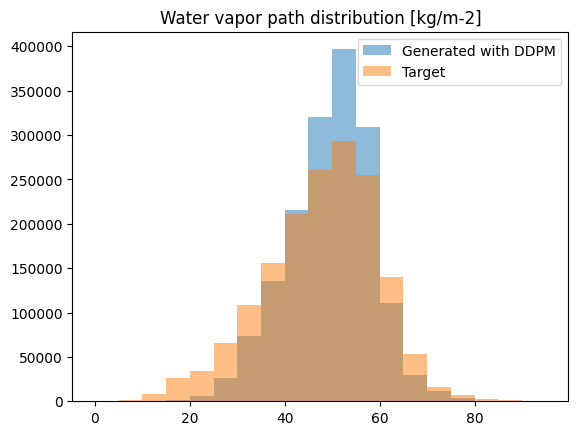

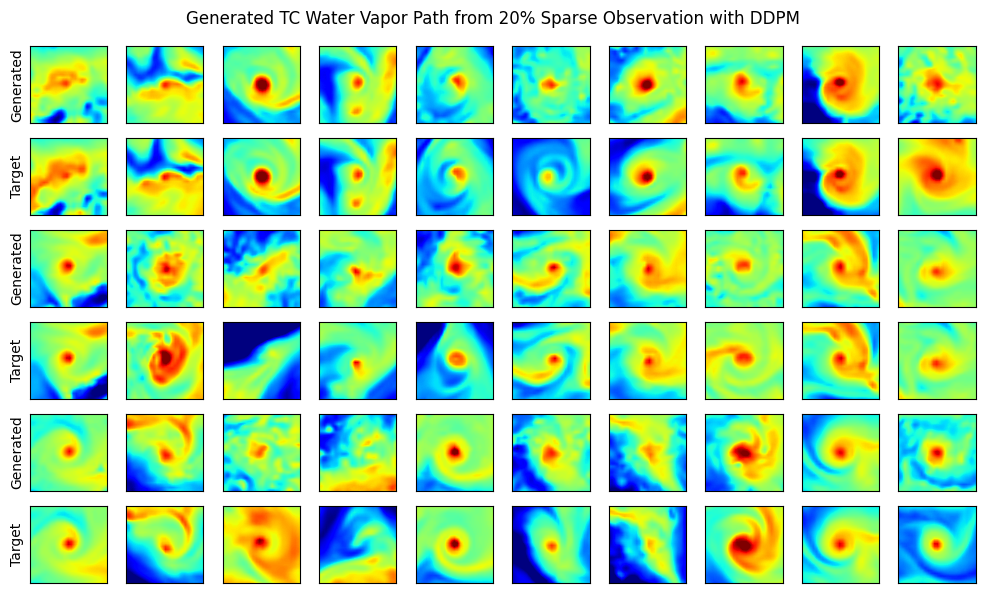

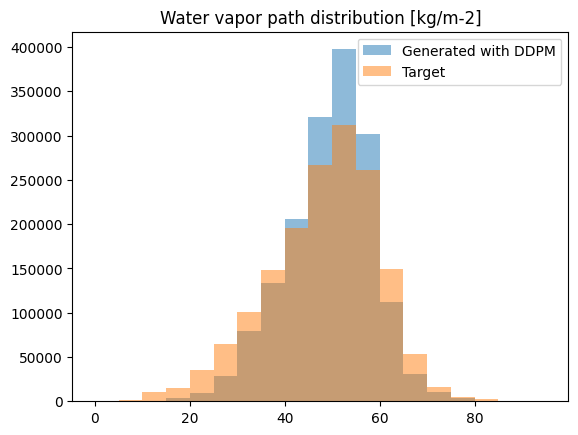

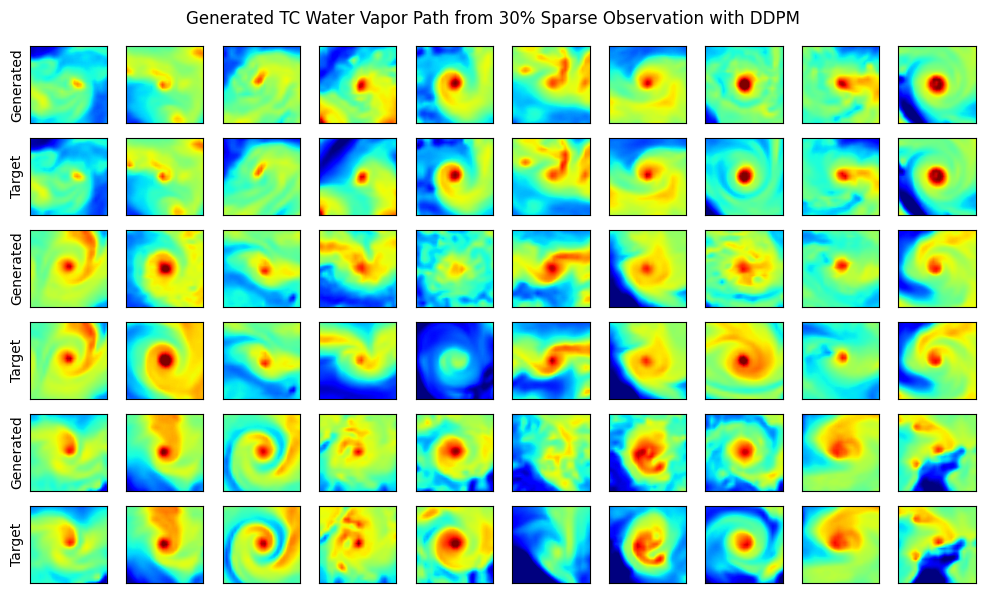

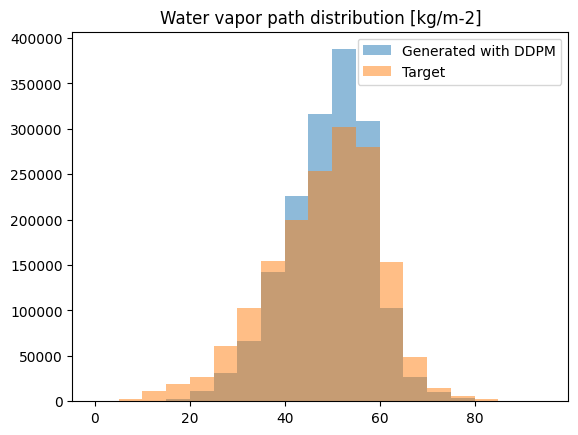

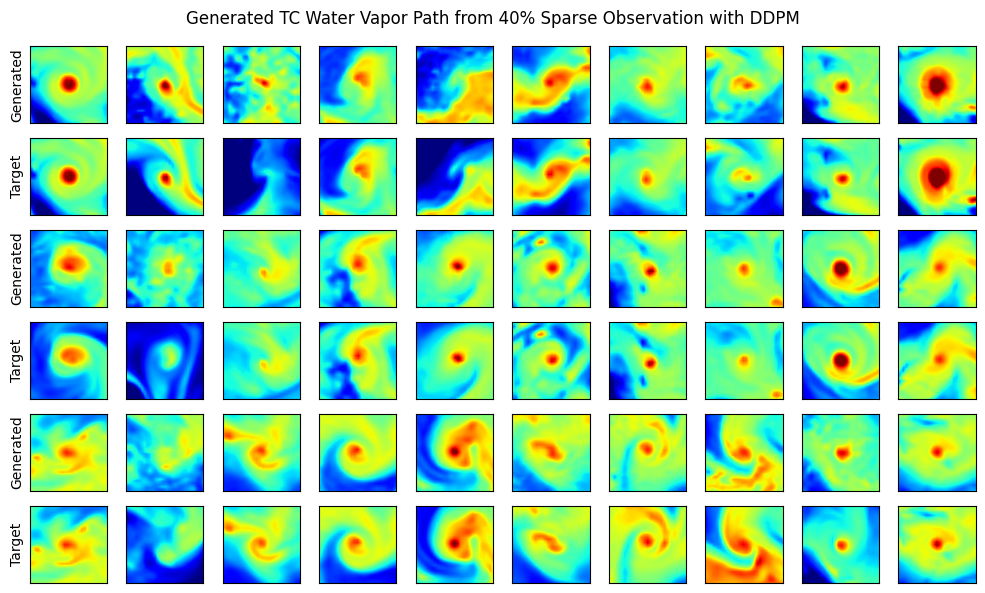

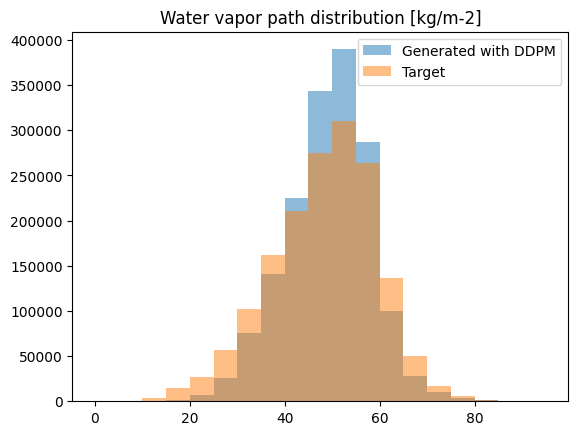

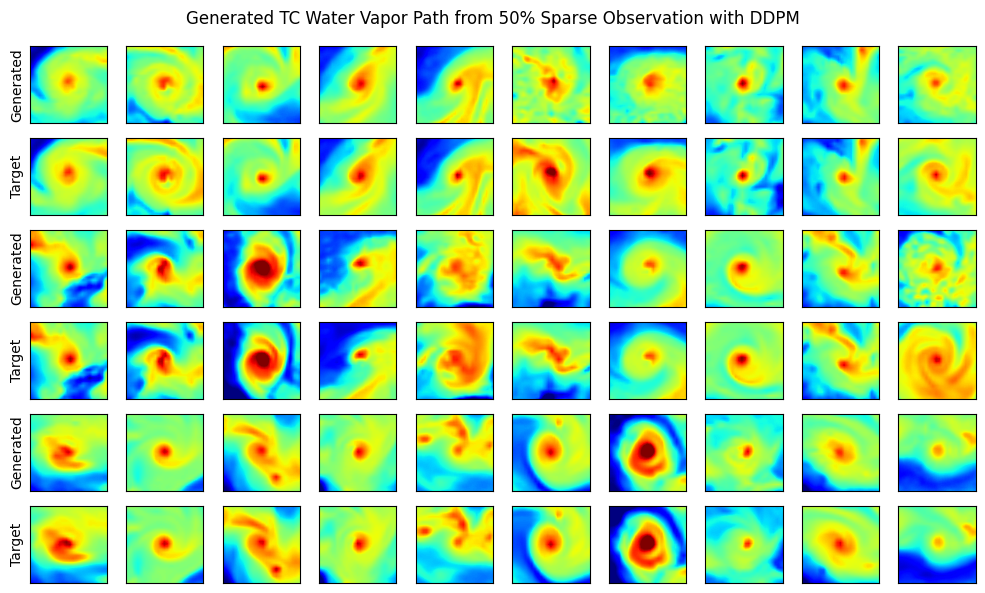

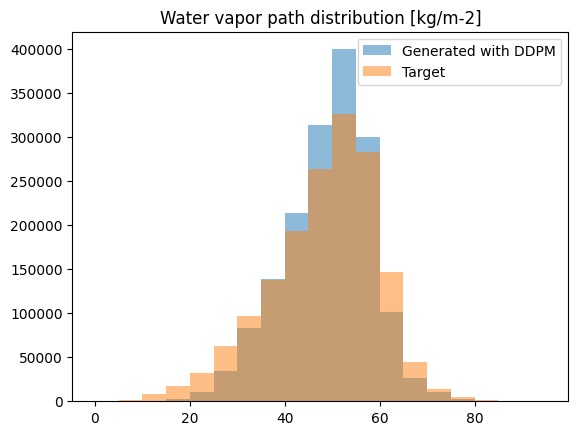

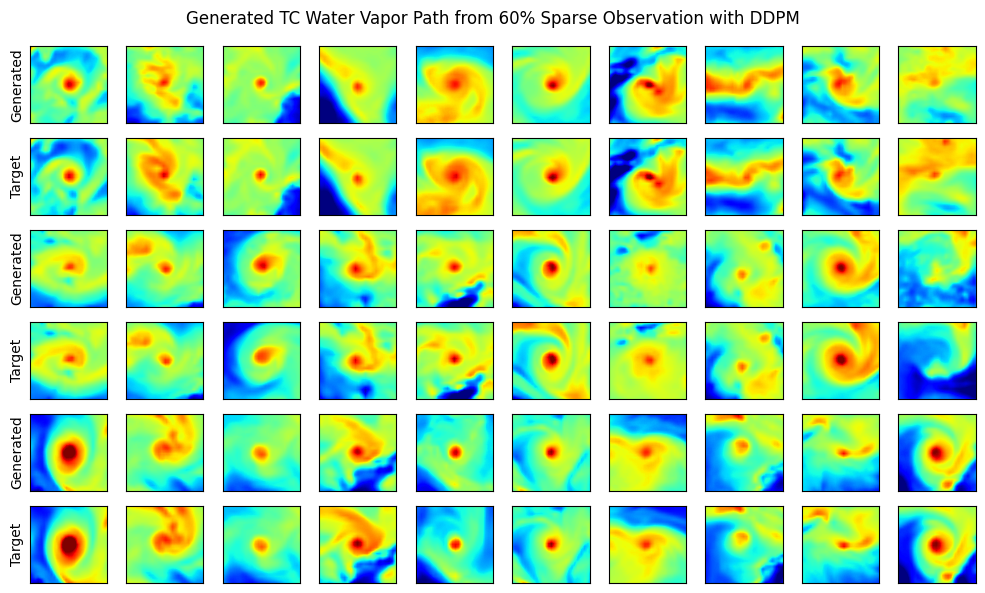

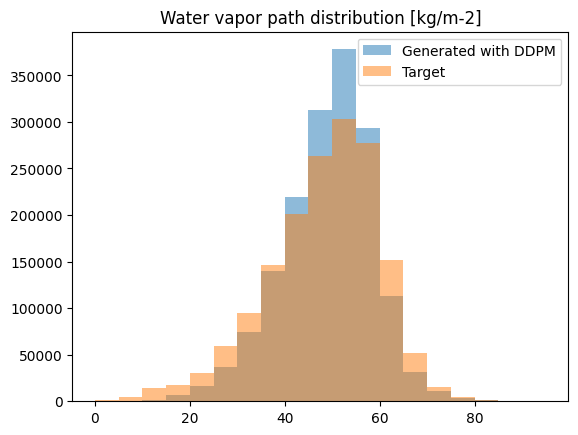

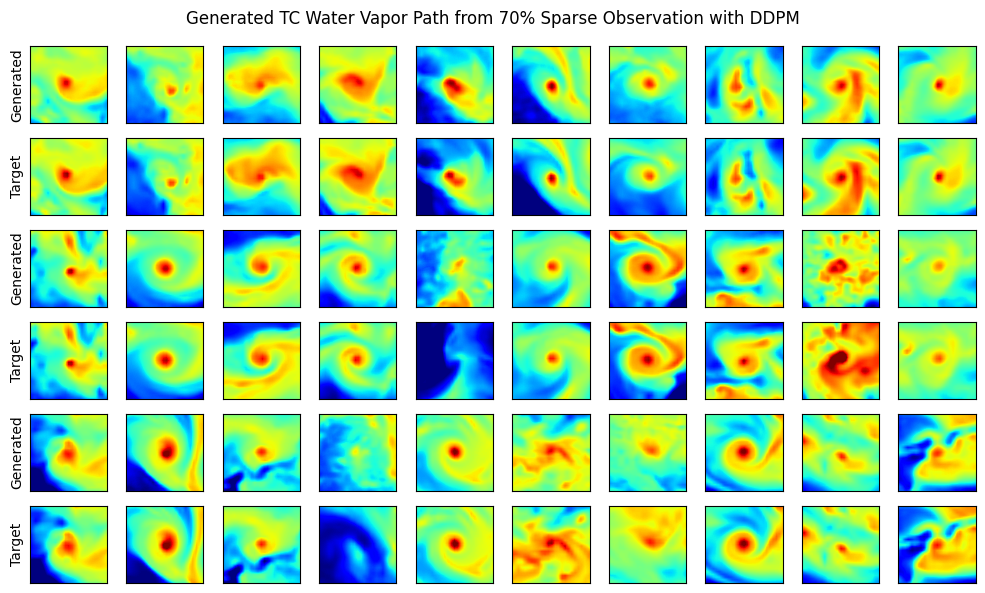

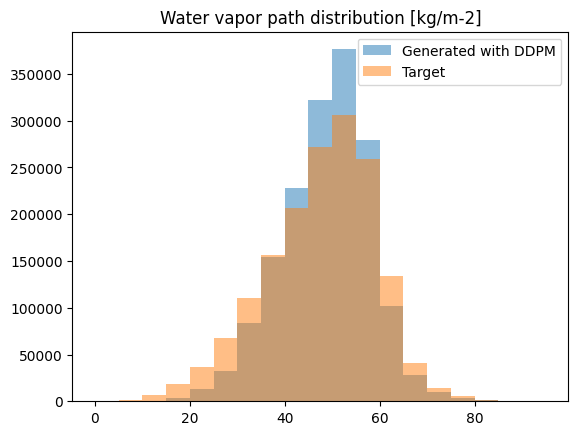

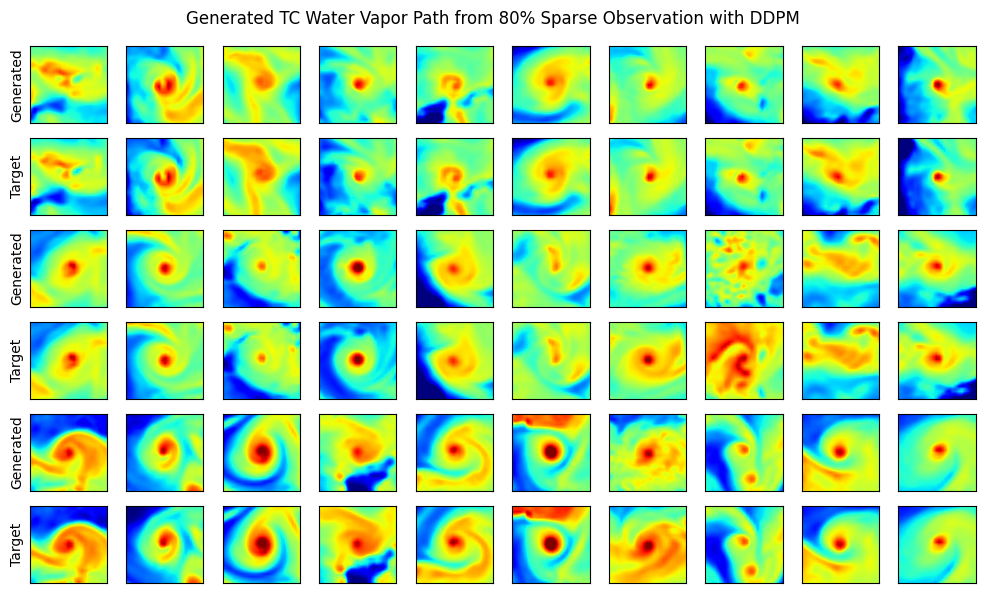

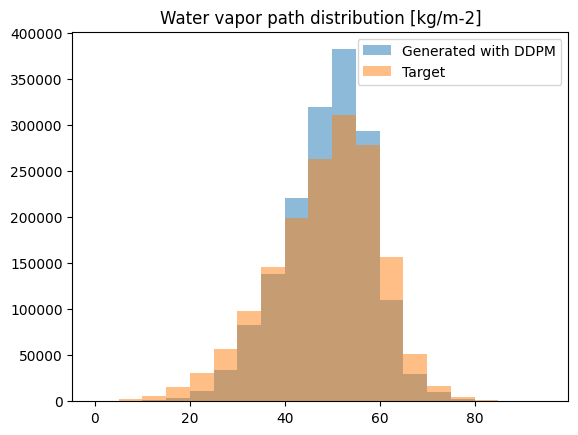

In [9]:
RMSE_all = []
obs_ratio_sample_list = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
for obs_ratio_sample in obs_ratio_sample_list:
    # sample xx images
    sample_batch_size = 256
    model_samples, target_samples = gen_samples(sample_batch_size, obs_ratio_sample, test_data)
    # unnorm
    model_samples = test_data.unnormalization(model_samples)
    target_samples = test_data.unnormalization(target_samples)
    RMSE = np.sqrt(np.mean((model_samples-target_samples)**2))
    RMSE_all.append(RMSE)
    
    
    model_samples_plot = rearrange(model_samples[:30], '(br bc) c h w -> br bc h w c', br=3)
    target_samples_plot = rearrange(target_samples[:30], '(br bc) c h w -> br bc h w c', br=3)
    suptitle = f"Generated TC Water Vapor Path from {obs_ratio_sample*100:.0f}% Sparse Observation with DDPM"
    fig = plot(model_samples_plot, ['Generated', 'Target'], target_samples_plot, suptitle) 
    fig.savefig(results_folder/f'gen_tc_{obs_ratio_sample*100:.0f}_sample.png', dpi=200)
    fig,ax = plt.subplots()
    plt.hist(model_samples.flatten(),bins=np.arange(0,100,5),alpha=0.5,label='Generated with DDPM')
    plt.hist(target_samples.flatten(),bins=np.arange(0,100,5),alpha=0.5,label='Target')
    plt.title('Water vapor path distribution [kg/m-2]')
    plt.legend()
    fig.savefig(results_folder/f'gen_tc_{obs_ratio_sample*100:.0f}_hist.png', dpi=200)

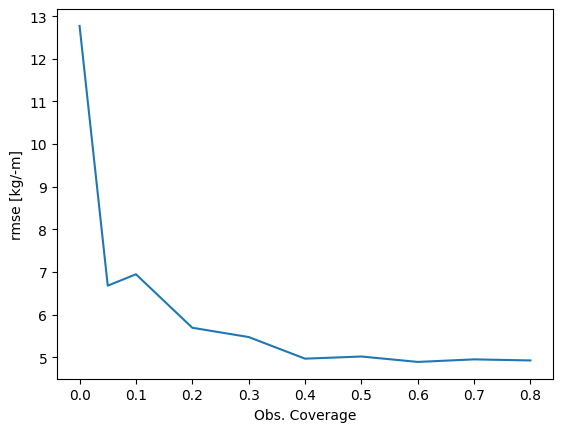

In [10]:
plt.plot(obs_ratio_sample_list, RMSE_all)
plt.xlabel('Obs. Coverage')
plt.ylabel('rmse [kg/-m]')
fig.savefig(results_folder/f'gen_tc_rmse_obs_coverage.png')